In [1]:
import sys
import os
sys.path.append(os.getcwd())
sys.path.append(r"D:\workspace\SPECT_project\RadiSmart")


import os
import numpy as np
import SimpleITK as sitk
from scipy.ndimage import zoom

from advanced_segment import cal_lv_mask
from cardiac.cadc_integrate import generate_bull_eye_image

In [2]:
# DATA_COLLECTION = "/mnt/labnas/DataCollection"
DATA_COLLECTION = r"Y:\labspace\DataCollection"
# base_dir = os.path.join(DATA_COLLECTION, "Project", "RadiSmart", "cardiac", "healthy")
base_dir = os.path.join(DATA_COLLECTION, "Project", "RadiSmart", "cardiac", "demo")
img_path = os.path.join(base_dir, "000652515", "154")
# img_path = os.path.join(base_dir, "000149118", "101")
# img_path = os.path.join(base_dir, "002475009", "402")
# img_path = os.path.join(base_dir, "600860468", "997")
# img_path = os.path.join(base_dir, "600360681", "1081")

# demo list
# img_path = os.path.join(base_dir, "001398670", "263")


def read_sitk_img(path, zoom_factor = 3):
    sitk_img = sitk.ReadImage(path)
    img_arr = sitk.GetArrayFromImage(sitk_img)
    # SimpleITK: image[x,y,z]; numpy: image_numpy_array[z,y,x]
    # print(f"img meta: \n shape:{img_arr.shape} \n spacing:{sitk_img.GetSpacing()[::-1]}")
    width = 20
    # 计算中心位置
    center = np.array(img_arr.shape)//2
    start = center - width//2
    end = center + width//2
    
    clipped_img_arr = img_arr[:, start[1]:end[1], start[2]:end[2]].copy()
    
    zoomed_clipped_img_arr = zoom(clipped_img_arr, zoom_factor, cval=0)
    voxel_size = np.array(sitk_img.GetSpacing()[::-1])/zoom_factor
    return zoomed_clipped_img_arr, voxel_size

zoom_factor = 3
zoomed_clipped_non_gate_img3d, voxel_size = read_sitk_img(img_path, zoom_factor) 

lv_mask, param = cal_lv_mask(zoomed_clipped_non_gate_img3d, voxel_size, True)


img meta: 
 shape:(51, 60, 60) 
 spacing:[2.21456667 2.21456633 2.21456633]
限制条件:  min_volume(mm^3):40000, min_distance(mm):100
当前连通域:  volume:69442.2658995146, distance:23.98620505524861
naive_segment_lv_mask Success
{
    "center": {
        "cy": 25.820621468926554,
        "cx": 28.52683615819209
    },
    "radius": 8.938213115881021,
    "apex_z": 0,
    "base_z": 41,
    "dividing_z": 17.876426231762043
}
True True False True
loop
True True True True
*******************************final_param*******************************
{
    "center": {
        "cy": 25.34241586168165,
        "cx": 27.47235848531006
    },
    "radius": 11.0,
    "apex_z": 4,
    "base_z": 37.86666666666667,
    "z_map": null,
    "dividing_z": 26.0
}
*******************************final_param_with_plane*******************************
{
    "center": {
        "cy": 25.34241586168165,
        "cx": 27.47235848531006
    },
    "radius": 11.0,
    "apex_z": 4,
    "base_z": 37.86666666666667,
    "z_map": nu

In [4]:
zs, ys, xs = np.where(lv_mask>0)

apex_z = np.min(zs)
base_z = np.max(zs) + 1

apex_c1 = np.round(apex_z+(base_z-apex_z)/4).astype(np.int8)
apex_mid = np.round(apex_z+(base_z-apex_z)/4*2).astype(np.int8)
apex_c2 = np.round(apex_z+(base_z-apex_z)/4*3).astype(np.int8)

# 大小排序 apex_z < apex_c1 < apex_mid < apex_c2 < base_z


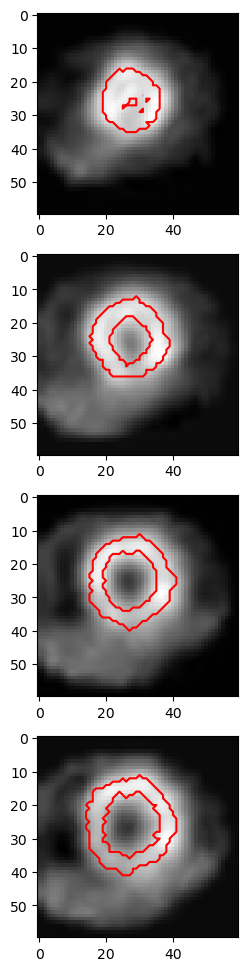

In [31]:
bul_img = np.zeros((128, 128), np.float32)
# fuc 生成不同层短轴图像
zs, ys, xs = zoomed_clipped_non_gate_img3d.shape

max_r = 12
cvr_val = int(min([8, max_r]))


# 整合心基、室中、心尖、心尖顶端图像
slc_img = np.zeros((4, ys, xs))
slc_img[0] = np.max(zoomed_clipped_non_gate_img3d[apex_z:apex_c1], axis=0)
slc_img[1] = np.max(zoomed_clipped_non_gate_img3d[apex_c1:apex_mid], axis=0)
slc_img[2] = np.max(zoomed_clipped_non_gate_img3d[apex_mid:apex_c2], axis=0)
slc_img[3] = np.max(zoomed_clipped_non_gate_img3d[apex_c2:base_z], axis=0)

slc_msk_img = np.zeros((4, ys, xs), np.uint8)

slc_msk_img[0] = np.max(lv_mask[apex_z:apex_c1], axis=0)
slc_msk_img[1] = np.max(lv_mask[apex_c1:apex_mid], axis=0)
slc_msk_img[2] = np.max(lv_mask[apex_mid:apex_c2], axis=0)
slc_msk_img[3] = np.max(lv_mask[apex_c2:base_z], axis=0)


plt.figure(figsize=(12, 12))
for i in range(4):
    plt.subplot(4, 1, i+1)
    plt.imshow(slc_img[i], cmap="gray")
    plt.contour(slc_msk_img[i], levels=[0.5], colors='r')

In [32]:
cz, cy, cx = np.array(zoomed_clipped_non_gate_img3d.shape) / 2


from cardiac.cadc_integrate import determinate_left_ventricle_in_ou_radius, integrate_slice_images_to_origin_bull_eye_image 
# 确定各层内外径
slc_rad, tol_rad = determinate_left_ventricle_in_ou_radius(slc_img, slc_msk_img, cx, cy, max_r)

print(slc_rad)



[[ 0  8  8]
 [ 3  9  6]
 [ 5 10  5]
 [ 7 11  4]]


0 22 0 22
19.0 41.0 19.0 41.0


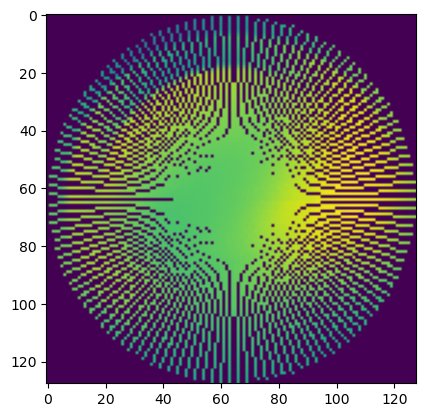

In [33]:
# 生成原始牛眼图
bul_img = integrate_slice_images_to_origin_bull_eye_image(slc_img, slc_rad, cx, cy, cvr_val)

plt.imshow(bul_img)

In [34]:
# 原始牛眼图映射到扇形分区
# sec_img = np.load(r'D:\CardiacSPECT\sector.npy')
# sec_img = np.load(r'E:\workspace\cardiac_project\develop_SPECT\sector.npy')

resource_dir = r"D:\workspace\SPECT_project\RadiSmart\cardiac\resource"
# print(os.getcwd())
# print(resource_dir)
sec_img = np.load(os.path.join(resource_dir, 'sector.npy'))
# sec_img = np.load(deploy.get_resource_path('sector.npy'))

cnt = int(sec_img.max())
for i in range(1, cnt + 1):
    idx = np.where(sec_img == i)
    px_val = bul_img[idx[0][:], idx[1][:]]
    bul_img[idx[0][:], idx[1][:]] = np.max(px_val)

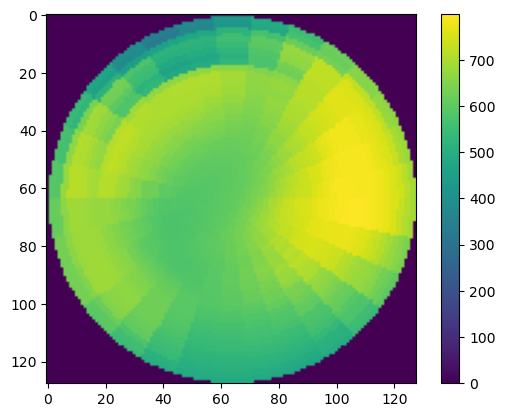

In [35]:
import matplotlib.pyplot as plt

plt.imshow(bul_img)

plt.colorbar()